# SVM para la detección de diabetes

En este ejercicio intentamos crear una SVM que permita identificar pacientes con diabetes conociendo únicamente sus características físicas, sin necesidad de realizar un examen específico sobre el tema. Contamos con datos de 768 pacaientes, los cuales están identificados on `0` en caso de no tener diabetes y con `1` en caso de tener un diagnóstico positivo.

La tarea será realizada con una SVM de **clasificación**, que será relizada con la clas `SVC` de la librería `sklearn`.

In [1]:
# Manipulación de datos
import pandas as pd
# Operaciones numéricas
import numpy as np
# Para medición del tiempo que toma ejecutar los procesos
from time import time
# Para separar datos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
# Librería para SVM
from sklearn.svm import SVC
# Medición de precisión
from sklearn.metrics import accuracy_score, confusion_matrix
# Generar gráficos
import matplotlib.pyplot as plt

In [2]:
# Leemos el set de datos y lo cargamos en la variable df, que es un DataFrame de pandas
diabetes_df = pd.read_csv('diabetes.csv')
# Mostrar información sobre el set de datos
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Siempre es recomendable explorar el set de datos antes de realizar un análisis sobre el mismo. En este caso, simplemente mostraremos los primeros cinco registros para conocer cómo se componen.

In [3]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Nuestro objetivo será predecir la columna `Outcome`, que contiene el resultado del diagnóstico. Es importante comprender de qué manera se distribuyen las muestras para identificar posibles fallas y tendencias falsas (sesgos) en nuestro algoritmo.

In [4]:
# Contar los valores únicos de una columna en un DataFrame
diabetes_df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

En este caso, tenemos muchas más muestras de pacientes diagnosticados sin diabetes (`0`). Esto podría representar un problema para las predicciones de nuestra SVM, pues estará sesgada a predecir más resultados de la clase que contiene más muestras.

Para empezar el proceso de entrenamiento, es necesario separar las características (`X`) de las etiquetas (`y`). El objetivo de todo el análisis es poder predecir una etiqueta `y`, contando únicamente con las características (`y`). La SVM se encargará de aprender la relación que existe entre `X` y `y`.

In [5]:
# Crearemos un nuevo df llamado X (notar mayus) con las columnas de características
# Se obtiene generando una lista de columnas del df a utilizar
lista_caract = [
    'Pregnancies',
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'BMI',
    'DiabetesPedigreeFunction',
    'Age'
]
# Luego tomando esa lista del df original
X = diabetes_df[lista_caract]
# Mostraremos los primeros cinco registros para conocer cómo se compone X
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [6]:
# Utilizaremos el mismo procedimiento para generar y
lista_etiq = ['Outcome']
y = diabetes_df[lista_etiq]
y.head()

,Outcome
0,1
1,0
2,1
3,0
4,1


Ahora que tenemos nuestros objetos de `X` y `y`, procederemos a separarlos en conjuntos de **entrenamiento** (que serviran para aprender) y **prueba** (para validadr que el aprendizaje sea correcto.

Este proceso será realizado con la función `train_test_split` que importamos al inicio del documento. Por defecto, esta función tomará 25% (`0.25`) de nuestro conjunto total de datos como prueba y el resto para entrenamiento.

In [7]:
# Separar en datos de entrenamiento y datos de prueba
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y
)

In [8]:
# Mostraremos la cantidad de datos a utilizar para el entrenamiento
X_train.shape

(576, 8)

In [9]:
# Luego, la cantidad de datos a utilizar para validar
X_test.shape

(192, 8)

### Creación de la SVM

Utilizaremos la clase `SVC` (Support Vector Classifier) que importamos al inicio. Como vimos en [la introducción](3-2_svm-intro.ipynb), existen diversos tipos de kernel que podemos utilizar para crear una SVM. En este caso tomaremos un kernel **lineal** (en sklearn `linear`) para que el entrenamiento sea rápido.

In [10]:
# Definició del modelo que llamaremos clf
clf = SVC(kernel='linear')

El entrenamiento de un modelo en sklearn es bastante sencillo. Basta con llamar el método `fit` para encontrar las relaciones entre nuestra `X` y `y`. El único inconveniente es que el método `fit` recibe valores de tipo `array`, pero nuestros datos actualmente se encuentran contenidos en objetos de tipo `pandas.DataFrame` (df). Para convertir un df en un array, basta con tomar el atributo `values` del mismo df.

In [11]:
# Guardamos el registro del momento en el que empezamos el entrenamiento
hora_inicio = time()

# Iniciamos el entrenamiento ejecutando el metodo fit
# Los valores que enviamos son los valores de X y y
#
# El .ravel() que final de y.values es un pequeño truco para cambiar su forma
# esto permite convertir una matriz de dos dimensiones en una sola dimesión,
# con ello, cada elemento de esta nueva matriz corresponde a un registro de X
clf.fit(X_train.values, y_train.values.ravel())

# Imprimimos el tiempo tomado para el entrenamiento
print("Entrenamiento terminado en {} segundos".format(time() - hora_inicio))

Entrenamiento terminado en 2.9202382564544678 segundos


Una vez terminado el entrenamiento, es necesario medir su precisión. Para ello, intentaremos predecir los datos de nuestra `y` de prueba utilizando nuestra `X` de prueba. A estos datos les llamaremos `y_pred`, pues contendrán nuestra predicción.

In [12]:
# Otra vez guardaremos registro del tiempo que nos toma crear esta predicción
hora_inicio = time()
# Iniciamos la predicción con nuestra X de prueba
y_pred = clf.predict(X_test)
# Mostramos el tiempo tomado para la predicción
print("Predicción terminada en {} segundos".format(time() - hora_inicio))

Predicción terminada en 0.002992391586303711 segundos


Una vez terminada nuestra predicción, podemos comparar su precisión con la función `accuracy_score`. Esto se encargará de mostrarnos el porcentaje de predicciones correctas realizadas por nuestro modelo.

In [13]:
# Evaluamos la precisión 
accuracy_score(y_test, y_pred)

0.7708333333333334

En este caso, la precisión del modelo fue relativamente aceptable (0.79). Sin embargo, debido a que los datos de aprendizaje fueron muy pocos (cerca de 500) y que estaban muy sesgados hacia la clase más representada (la gente sin diabetes), es posible que no funcione bien en muchos casos.

### Matriz de confusión

Una matriz de confusión nos ayuda a tener una mejor idea del rendimiento de nuestro modelo. Se encarga de comparar la cantidad de aciertos de cada clase de nuestros datos de prueba (`y_test` en este caso) y nuestros datos calculados (`y_pred` en este caso).

In [14]:
# La función confusion_matrix recibe las "respuestas correctas" y nuestras predicciones
# genera una matriz que indica, para cada clase, la cantidad de predicciones correctas e incorrectas
conf_diabetes = confusion_matrix(y_test, y_pred)
conf_diabetes

array([[113,  13],
       [ 31,  35]], dtype=int64)

Debido a que es poco complicado comprender la matriz únicamente de forma numérica, vamos a crear una función que lo muestre de forma gráfica.

In [15]:
def plot_cm(cm, classes):
    """Esta función se encarga de generar un gráfico con nuestra matriz de confusión.
    cm es la matriz generada por confusion_matrix
    classes es una lista que contiene las posibles clases que puede predecir nuestro modelo
    """
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Matriz de confusión')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for indice_fila, fila in enumerate(cm):
        for indice_columna, columna in enumerate(fila):
            if cm[indice_fila, indice_columna] > thresh:
                color = "white"
            else:
                color = "black"
            plt.text(
                indice_columna,
                indice_fila,
                cm[indice_fila, indice_columna],
                color=color,
                horizontalalignment="center"
            )
    plt.ylabel("Valores reales")
    plt.xlabel("Valores calculados")
    plt.show()

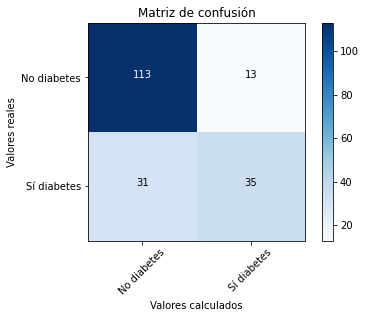

In [16]:
# Generamos el gráfico llamando la función que creamos y enviando los parámetros
# cm = nuestra matriz de confusión (conf_diabetes)
# classes = las clases a predecir (si tienen diabetes o no)
plot_cm(conf_diabetes, ['No diabetes', 'Sí diabetes'])